In [1]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"../")
import mplhep as hep
import pickle
import glob
import ROOT as rt
import coffea
import awkward as ak
from coffea import hist, processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector
import os

Warning in <TInterpreter::ReadRootmapFile>: class  HepMC::FourVector found in libSimDataFormatsGeneratorProducts.so  is already in libHepMC3rootIO.so 


Welcome to JupyROOT 6.28/00


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  r

In [2]:
#import helper modules for muon scale factor computation
sys.path.append("/storage/af/user/aalbert/CMSSW_14_1_0_pre4/src/RazorCommon_correctionslib/RazorCommon/Tools/bin")
import importlib
import getMuonScaleFactor

In [3]:
ak.behavior.update(candidate.behavior)

def getLZDF(f,nEvents=-1,version="new"): #lazy dataframe with events that have cluster matched to probe muon
    events_raw = uproot.open(f)['MuonSystem']
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    #events = events[start:stop]
    return events

In [4]:
#paths
MC_paths = {"2022":"/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/MC_VetoEff/MC_Summer22/DYto2Mu_MLL-50to120_keepMDSHits_Merged/DYto2Mu_MLL-50to120_keepMDSHits_7311pb_weighted.root",
            "2022EE":"/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/MC_VetoEff/MC_Summer22EE/DYto2Mu_MLL-50to120_keepMDSHits_Merged/DYto2Mu_MLL-50to120_keepMDSHits_26642pb_weighted.root",
            "2023":"/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/MC_VetoEff/MC_Summer23/DYto2Mu_MLL-50to120_Merged/DYto2Mu_MLL-50to120_18411pb_weighted.root",
            "2023BPix":"/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/MC_VetoEff/MC_Summer23BPix/DYto2Mu_MLL-50to120_Merged/DYto2Mu_MLL-50to120_9451pb_weighted.root",
           "2024":"/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/MC_VetoEff/MC_Summer24/DYto2Mu_MLL-50to120_Merged/DYto2Mu_MLL-50to120_108753pb_weighted.root"
           }

data_path_lists = {"2022":["/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2022_Merged/Muon_Run2022C_PromptReco-v1_goodLumi.root",
                          "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2022_Merged/Muon_Run2022D_PromptReco-v1_goodLumi.root"],
                 
                   "2022EE":["/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2022_Merged/Muon_Run2022E_PromptReco-v1_goodLumi.root",
                          "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2022_Merged/Muon_Run2022F_PromptReco-v1_goodLumi.root",
                            "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2022_Merged/Muon_Run2022G_PromptReco-v1_goodLumi.root"],
                   
                    "2023":["/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023B_PromptReco-v1_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023B_PromptReco-v1_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023C_PromptReco-v1_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023C_PromptReco-v1_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023C_PromptReco-v2_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023C_PromptReco-v2_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023C_PromptReco-v3_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023C_PromptReco-v3_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023C_PromptReco-v4_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023C_PromptReco-v4_goodLumi.root"],
                  
                      "2023BPix":["/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023D_PromptReco-v1_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023D_PromptReco-v1_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023D_PromptReco-v2_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023D_PromptReco-v2_goodLumi.root"],
                       
                    "2024":["/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024B-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024C-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024D-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024E-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024E-PromptReco-v2-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024F-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024G-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024H-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024I-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024I-PromptReco-v2-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024B-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024C-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024D-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024E-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024E-PromptReco-v2-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024F-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024G-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024H-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024I-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024I-PromptReco-v2-AOD_goodLumi.root"]
                      
                             }

In [5]:
#events_data = getLZDF(data_path)
events_MC_full_dict= {}
for campaign, MC_path in MC_paths.items():
    #if "2024"!=campaign:continue
    print(campaign)
    events_MC_full = getLZDF(MC_path)
    events_MC_full = events_MC_full[np.logical_and(events_MC_full.ZMass>50, events_MC_full.ZMass<120)]
    events_MC_full = events_MC_full[np.logical_and(events_MC_full.Flag_all, events_MC_full.Flag_ecalBadCalibFilter)]
    events_MC_full = events_MC_full[events_MC_full.jetVeto]
    events_MC_full_dict[campaign] = events_MC_full

2022
2022EE
2023
2023BPix
2024


In [6]:
events_data_full_dict= {}
for campaign, data_path_list in data_path_lists.items():
    #if "2022"!=campaign:continue
    print(campaign)
    data_events = [getLZDF(data_path) for data_path in data_path_list]
    events_data_full = ak.concatenate(data_events, axis=0)
    events_data_full = events_data_full[np.logical_and(events_data_full.ZMass>50, events_data_full.ZMass<120)]
    events_data_full = events_data_full[np.logical_and(events_data_full.Flag_all, events_data_full.Flag_ecalBadCalibFilter)]
    events_data_full = events_data_full[events_data_full.jetVeto]
    events_data_full_dict[campaign] = events_data_full

2022
2022EE
2023
2023BPix
2024


In [7]:
branch_names = ["weight", "ZMass","npv", "pileupWeight","sampledEta","sampledPhi"]

In [8]:
MC_kFactors = {"2022":0.9202108866645403,"2022EE":0.9205275233052539,"2023":0.9287192347533128,"2023BPix":0.938125553192627,"2024":0.9070469152942339}

In [9]:
#get low MET weights from signal cluster distributions
lowMET_CSCCSC = rt.TFile.Open("clusterDistributionsForVeto/lowMET/CSCCSC.root","READ")
lowMET_CSCHist = lowMET_CSCCSC.Get("CscClusters0").Clone()
lowMET_CSCHist.SetDirectory(0)
second_CSC = lowMET_CSCCSC.Get("CscClusters1").Clone()
second_CSC.SetDirectory(0)
lowMET_CSCHist.Add(second_CSC)
lowMET_CSCHist.Scale(1/lowMET_CSCHist.GetSumOfWeights())

lowMET_DTCSC = rt.TFile.Open("clusterDistributionsForVeto/lowMET/DTCSC.root","READ")
lowMET_DTHist = lowMET_DTCSC.Get("DtClusters").Clone()
lowMET_DTHist.SetDirectory(0)
lowMET_DTHist.Scale(1/lowMET_DTHist.GetSumOfWeights())

In [10]:
#new code to put code in histograms with same binning as Christinas
import h5py
dist = "clusterDistributionsForVeto/highMET/eta-phi-dist.h5"
with h5py.File(dist, 'r') as hf:
    print("Keys: %s" % hf.keys())
    csc_eta = np.abs(np.array(hf["csc_eta"],dtype=float))
    csc_weight = np.array(hf["csc_weight"],dtype=float)
    dt_eta = np.abs(np.array(hf["dt_eta"],dtype=float))
    dt_weight = np.array(hf["dt_weight"],dtype=float)
print(type(csc_eta))
print(np.max(csc_eta))
print(np.min(csc_eta))
print(np.max(dt_eta))
print(np.min(dt_eta))
print(np.size(csc_weight))

Keys: <KeysViewHDF5 ['csc_eta', 'csc_phi', 'csc_weight', 'dt_eta', 'dt_phi', 'dt_weight']>
<class 'numpy.ndarray'>
2.4375078678131104
0.9080042839050293
1.1732056140899658
5.364419735087722e-07
516817


In [11]:
#build new histograms with same binning as low MET histograms
#NBinsCSC = lowMET_CSCHist.GetNbinsX()
# print(lowMET_CSCHist.GetNbinsX())
# CSCBinEdges = []
# for i in range(NBinsCSC):
#     if i==0:
#         CSCBinEdges.append(lowMET_CSCHist.GetBinLowEdge(i))
#     CSCBinEdges.append(lowMET_CSCHist.GetBinLowEdge(i)+lowMET_CSCHist.GetBinWidth(i))
# CSCBinEdges


CSC_hist_eta = rt.TH1F("cscEta", "cscEta", nbinsx=50, xlow=0.9, xup=2.5)
DT_hist_eta = rt.TH1F("dtEta", "dtEta", nbinsx=50, xlow=0, xup=1.2)

print(np.size(csc_eta))
CSC_hist_eta.FillN(np.size(csc_eta), csc_eta, csc_weight)
DT_hist_eta.FillN(np.size(dt_eta), dt_eta, dt_weight)

CSC_hist_eta.Scale(1/CSC_hist_eta.GetSumOfWeights())
DT_hist_eta.Scale(1/DT_hist_eta.GetSumOfWeights())

highMET_CSCHist = CSC_hist_eta
highMET_DTHist = DT_hist_eta

516817


In [12]:
def getSFLoose(campaign, pt, eta):
    if campaign=="2022":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_preEE(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_preEE(pt, eta)
    elif campaign=="2022EE":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_EE(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_EE(pt, eta)
    elif campaign=="2023":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_preBPix(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_preBPix(pt, eta)
    elif campaign=="2023BPix" or campaign=="2024":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_BPix(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_BPix(pt, eta)
    else:
        print("invalid campaign. exiting...")
        exit()
    return MC_SF_LooseID, MC_SF_LooseISO

In [13]:
def getSFTight(campaign, pt, eta):
    if campaign=="2022":
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_preEE(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_preEE(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_preEE(pt, eta)
    elif campaign=="2022EE":
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_EE(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_EE(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_EE(pt, eta)
    elif campaign=="2023":
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_preBPix(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_preBPix(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_preBPix(pt, eta)
    elif campaign=="2023BPix" or campaign=="2024":
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_BPix(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_BPix(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_BPix(pt, eta)
    else:
        print("invalid campaign. exiting...")
        exit()
    return MC_SF_TightID, MC_SF_TightISO, MC_SF_HLT

In [14]:
def getSF(campaign, pt, eta):
    if campaign=="2022":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_preEE(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_preEE(pt, eta)
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_preEE(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_preEE(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_preEE(pt, eta)
    elif campaign=="2022EE":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_EE(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_EE(pt, eta)
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_EE(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_EE(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_EE(pt, eta)
    elif campaign=="2023":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_preBPix(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_preBPix(pt, eta)
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_preBPix(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_preBPix(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_preBPix(pt, eta)
    elif campaign=="2023BPix" or campaign=="2024":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_BPix(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_BPix(pt, eta)
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_BPix(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_BPix(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_BPix(pt, eta)
    else:
        print("invalid campaign. exiting...")
        exit()
    return MC_SF_LooseID, MC_SF_LooseISO, MC_SF_TightID, MC_SF_TightISO, MC_SF_HLT

In [15]:
def getBranches(LZDF, campagin, isMC=False):
    print("adding generic branches")
    new_df = ak.zip({field:LZDF[field]  for field in branch_names})
    
    #new_df = ak.zip({field: np.repeat(LZDF[field], LZDF["numTag"]) for field in branch_names})
#     for branch in branch_names:
#         if (not isMC) and (branch in ["weight", "pileupWeight"]):
#             continue
#         new_df = ak.with_field(new_df, np.repeat(LZDF[branch],LZDF["numTag"]), branch)
    #print("finished event level variables")
#     totalSize = ak.size(LZDF_big.ZMass)
#     print(type(totalSize))
#     chunkSize = totalSize // 10
#     print(chunkSize)
#     print(type(chunkSize))
#     df_list = []
#     for i in range(0, totalSize, chunkSize):
#         print("Processing Chunk ",i)
#         initial_mask = np.array([False]*totalSize)
#         initial_mask[i:i+chunkSize] = True
#         LZDF = LZDF_big[initial_mask]
#         print(ak.count_nonzero(LZDF.weight))
    lepTag_array = LZDF["lepTag"]
    lepTag_array = np.repeat(lepTag_array,np.array(LZDF["numTag"]), axis=0)
    arr = np.zeros(np.shape(lepTag_array)[0], dtype=bool)
    arr[::2] = 1  # Set even indices to 1
    mask = ak.all(lepTag_array, axis=1)
    mask_T_F = np.logical_and(arr, mask)
    mask_F_T = np.logical_and(np.logical_not(arr), mask)
    lepTag_array = np.array(lepTag_array)
    lepTag_array.reshape((np.array(mask_T_F).shape[0],2))
    lepTag_array[mask_T_F] = [True, False]
    lepTag_array[mask_F_T] = [False, True]

    row_indices = np.arange(lepTag_array.shape[0], dtype=int)
    column_indices_probe =np.where(lepTag_array==False)[1]
    column_indices_tag =np.where(lepTag_array==True)[1]

    #highMET CSC first
    print("computing low MET CSC weighting")
    highMET_CSCWeights = ak.Array([0]*ak.count_nonzero(new_df.ZMass))
    for binNum in range(highMET_CSCHist.GetNbinsX()):
        leftEdge = highMET_CSCHist.GetBinLowEdge(binNum)
        rightEdge = leftEdge + highMET_CSCHist.GetBinWidth(binNum)
        highMET_CSCWeights = ak.where(np.logical_and(np.abs(new_df.sampledEta)>=leftEdge, np.abs(new_df.sampledEta)<rightEdge),highMET_CSCHist.GetBinContent(binNum), highMET_CSCWeights)
    new_df = ak.with_field(new_df,highMET_CSCWeights, "highMET_CSCWeights")
    
    highMET_DTWeights = ak.Array([0]*ak.count_nonzero(new_df.ZMass))
    print("computing low MET DT weighting")
    for binNum in range(highMET_DTHist.GetNbinsX()):
        leftEdge = highMET_DTHist.GetBinLowEdge(binNum)
        rightEdge = leftEdge + highMET_DTHist.GetBinWidth(binNum)
        highMET_DTWeights = ak.where(np.logical_and(np.abs(new_df.sampledEta)>=leftEdge, np.abs(new_df.sampledEta)<rightEdge),highMET_DTHist.GetBinContent(binNum), highMET_DTWeights)
    new_df = ak.with_field(new_df,highMET_DTWeights, "highMET_DTWeights")
    
    
    
    
    if isMC:
        MC_SF_LooseID, MC_SF_LooseISO, MC_SF_TightID, MC_SF_TightISO, MC_SF_HLT = getSF(campaign, np.array(LZDF.lepPt), np.array(LZDF.lepEta))

        MC_SF_LooseID = np.repeat(MC_SF_LooseID,np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_probe]
        MC_SF_LooseISO = np.repeat(np.array(MC_SF_LooseISO),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_probe]
        MC_SF_TightID = np.repeat(MC_SF_TightID,np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_tag]
        MC_SF_TightISO = np.repeat(MC_SF_TightISO,np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_tag]
        MC_SF_HLT = np.repeat(MC_SF_HLT,np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_tag]

        MC_Weight_Total = new_df.weight*MC_SF_LooseID*MC_SF_LooseISO*MC_SF_TightID*MC_SF_TightISO*MC_SF_HLT*new_df.pileupWeight*MC_kFactors[campaign]
        #MC_Weight_Total = MC_Weight_Total*0.9287192347533128 #k-factor to grab 2023 plot, comment out!!!!
        new_df = ak.with_field(new_df, MC_Weight_Total, "weight_total")

        
        
    
        
        
    
    
        
        
        
        #         LZDF_onetag = LZDF[LZDF.numTag==1]
#         LZDF_twotag = LZDF[LZDF.numTag==2]
        
#         #LZDF_onetag_probe = LZDF_onetag[LZDF_onetag.lepTag==False]
#         #LZDF_onetag_tag = LZDF_onetag[LZDF_onetag.lepTag]
#         print("computing one tag SFs")
#         MC_SF_LooseID, MC_SF_LooseISO = getSFLoose(campaign, np.array(ak.flatten(LZDF_onetag.lepPt[LZDF_onetag.lepTag==False])), np.array(ak.flatten(LZDF_onetag.lepEta[LZDF_onetag.lepTag==False])))
#         print("computed loose SFs")
#         MC_SF_TightID, MC_SF_TightISO, MC_SF_HLT = getSFTight(campaign, np.array(ak.flatten(LZDF_onetag.lepPt[LZDF_onetag.lepTag])), np.array(ak.flatten(LZDF_onetag.lepEta[LZDF_onetag.lepTag])))
#         print("computed tight SFs")
#         MC_Weight_Total = LZDF_onetag.weight*MC_SF_LooseID*MC_SF_LooseISO*MC_SF_TightID*MC_SF_TightISO*MC_SF_HLT*LZDF_onetag.pileupWeight
#         print("computed total SF")
#         LZDF_onetag = ak.with_field(LZDF_onetag, MC_Weight_Total, "weight_total")
        
#         #for two tag case, compute 1-P(muon 1 fails loose criteria)-P(muon 2 fails loose criteria)-P(both muons fail tight criteria)
#         arr = np.zeros(np.shape(LZDF_twotag.lepTag),dtype=bool)
#         arr[:,0] = 1
#         print("computing two tag SFs")
#         Muon0_LooseID, Muon0_LooseISO = getSFLoose(campaign, np.array(LZDF_twotag.lepPt[arr]), np.array(LZDF_twotag.lepEta[arr]))
#         Muon1_LooseID, Muon1_LooseISO = getSFLoose(campaign, np.array(LZDF_twotag.lepPt[np.logical_not(arr)]), np.array(LZDF_twotag.lepEta[np.logical_not(arr)]))
        
#         Muon0_TightID, Muon0_TightISO, Muon0_SF_HLT = getSFTight(campaign, np.array(LZDF_twotag.lepPt[arr]), np.array(LZDF_twotag.lepEta[arr]))
#         Muon1_TightID, Muon1_TightISO, Muon1_SF_HLT = getSFTight(campaign, np.array(LZDF_twotag.lepPt[np.logical_not(arr)]), np.array(LZDF_twotag.lepEta[np.logical_not(arr)]))
        
#         print("computed individual SFs")
#         SF_Weight = 1 - (1-Muon0_LooseID*Muon0_LooseISO) - (1-Muon1_LooseID*Muon1_LooseISO) - (1-(1-Muon0_TightID*Muon0_TightISO*Muon0_SF_HLT)*(1-Muon1_TightID*Muon1_TightISO*Muon1_SF_HLT))
        
#         print("computed newSF weight")
#         MC_Weight_Total = LZDF_twotag.weight*SF_Weight*LZDF_twotag.pileupWeight
#         LZDF_twotag = ak.with_field(LZDF_twotag, MC_Weight_Total, "weight_total")
        
#         print("concatenating")
#         LZDF = ak.concatenate([LZDF_onetag, LZDF_twotag])
        
#         #compute SFs for "pileup" muons (DT ones require looseID)
        
#         print("computing pileupmuon SFs")
#         PileupMuon_DT_highMET_LooseID = getSFLoose(campaign, LZDF.matchedMuonPt_DT_highMET,matchedMuonEta_DT_highMET)[0]
#         PileupMuon_DT_highMET_LooseID = getSFLoose(campaign, LZDF.matchedMuonPt_DT_highMET,matchedMuonEta_DT_highMET)[0]
        

    #print("at muon variables")
    
#     if isMC: 
#         new_df = ak.with_field(new_df, LZDF.weight_total, "weight_total")
        #new_df = ak.with_field(new_df, PileupMuon_DT_highMET_LooseID, "DT_highMET_SF_LooseID")
        #new_df = ak.with_field(new_df, PileupMuon_DT_highET_LooseID, "DT_highMET_SF_LooseID")
    
    print("adding veto branches")
    new_df = ak.with_field(new_df, LZDF.sampledCSC, "sampledCSC")
    new_df = ak.with_field(new_df, LZDF.sampledDT, "sampledDT")
    
    new_df = ak.with_field(new_df, LZDF.numMatchedJets_CSC==0, "passJetVeto_CSC")
    new_df = ak.with_field(new_df, LZDF.numMatchedJets_DT==0, "passJetVeto_DT")
    
#     new_df = ak.with_field(new_df, LZDF.numMatchedMuons_CSC==0, "passMuonVeto_CSC")
#     new_df = ak.with_field(new_df, LZDF.numMatchedMuons_DT_highMET==0, "passMuonVeto_DT_highMET")
#     new_df = ak.with_field(new_df, LZDF.numMatchedMuons_DT_highMET==0, "passMuonVeto_DT_highMET")
    
    new_df = ak.with_field(new_df, LZDF.numMatchedRechits_CSC==0, "passRechitVeto_CSC")
    new_df = ak.with_field(new_df, LZDF.numMatchedRechits_DT==0, "passRechitVeto_DT")
    
    
    
    
#     #load pT, eta, and phi for tag and probe muons
#     probe_pT = np.repeat(np.array(LZDF["lepPt"]),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_probe]
#     probe_eta = np.repeat(np.array(LZDF["lepEta"]),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_probe]
#     probe_phi = np.repeat(np.array(LZDF["lepPhi"]),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_probe]

#     tag_pT = np.repeat(np.array(LZDF["lepPt"]),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_tag]
#     tag_eta = np.repeat(np.array(LZDF["lepEta"]),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_tag]
#     tag_phi = np.repeat(np.array(LZDF["lepPhi"]),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_tag]

#     new_df = ak.with_field(new_df, probe_pT, "probe_pT")
#     new_df = ak.with_field(new_df, probe_eta, "probe_eta")
#     new_df = ak.with_field(new_df, probe_phi, "probe_phi")

#     new_df = ak.with_field(new_df, tag_pT, "tag_pT")
#     new_df = ak.with_field(new_df, tag_eta, "tag_eta")
#     new_df = ak.with_field(new_df, tag_phi, "tag_phi")
    #df_list.append(new_df)
    #new_df_big = ak.concatenate(df_list) 
    return new_df

In [16]:
events_MC_dict = {}; events_data_dict={}
for campaign in list(events_MC_full_dict.keys()):
    #if campaign!="2022":continue
    print(campaign)
    print("MC")
    events_MC = getBranches(events_MC_full_dict[campaign], campaign, True)
    print("now data")
    events_data = getBranches(events_data_full_dict[campaign], campaign, False)
    events_MC_dict[campaign] = events_MC
    events_data_dict[campaign] = events_data

2022
MC
adding generic branches
computing low MET CSC weighting
computing low MET DT weighting
adding veto branches
now data
adding generic branches
computing low MET CSC weighting
computing low MET DT weighting
adding veto branches
2022EE
MC
adding generic branches
computing low MET CSC weighting
computing low MET DT weighting
adding veto branches
now data
adding generic branches
computing low MET CSC weighting
computing low MET DT weighting
adding veto branches
2023
MC
adding generic branches
computing low MET CSC weighting
computing low MET DT weighting
adding veto branches
now data
adding generic branches
computing low MET CSC weighting
computing low MET DT weighting
adding veto branches
2023BPix
MC
adding generic branches
computing low MET CSC weighting
computing low MET DT weighting
adding veto branches
now data
adding generic branches
computing low MET CSC weighting
computing low MET DT weighting
adding veto branches
2024
MC
adding generic branches
computing low MET CSC weightin

### High MET CSC

In [17]:
dirName="VetoEffPlots_highMETCSC"
os.makedirs(dirName, exist_ok=True)

dirNameJetVeto = "VetoEffPlots_highMETCSC/JetVeto"
dirNameRechitVeto = "VetoEffPlots_highMETCSC/RechitVeto"

os.makedirs(dirNameJetVeto, exist_ok=True)
os.makedirs(dirNameRechitVeto, exist_ok=True)

2022
data eff:  0.9708642312775675  - 0.0006597962459885531  +  0.0006457705386565538
MC eff:  0.9716332810407883  - 0.0006654467928641772  +  0.0006507976608036703
2022EE
data eff:  0.9709106290416588  - 0.00035291637021128697  +  0.0003488361663671613
MC eff:  0.9715739840481984  - 0.00035765420467315234  +  0.0003533656195918722
2023
data eff:  0.9717583841622339  - 0.0004032327897153243  +  0.0003977582061794882
MC eff:  0.9713775395178186  - 0.00041110602207727887  +  0.0004054942854295751
2023BPix
data eff:  0.9718870119644097  - 0.000559523215614921  +  0.0005490174565460082
MC eff:  0.9712613464783737  - 0.0005723382961395629  +  0.0005615925651509812
2024
data eff:  0.9699099723620928  - 0.00017035975154067184  +  0.0001694329252508453
MC eff:  0.973031314755098  - 0.00016497020490624514  +  0.0001639978519437646


Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TFile::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: denom (Potential memory leak).
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TCanvas::Print>: png file

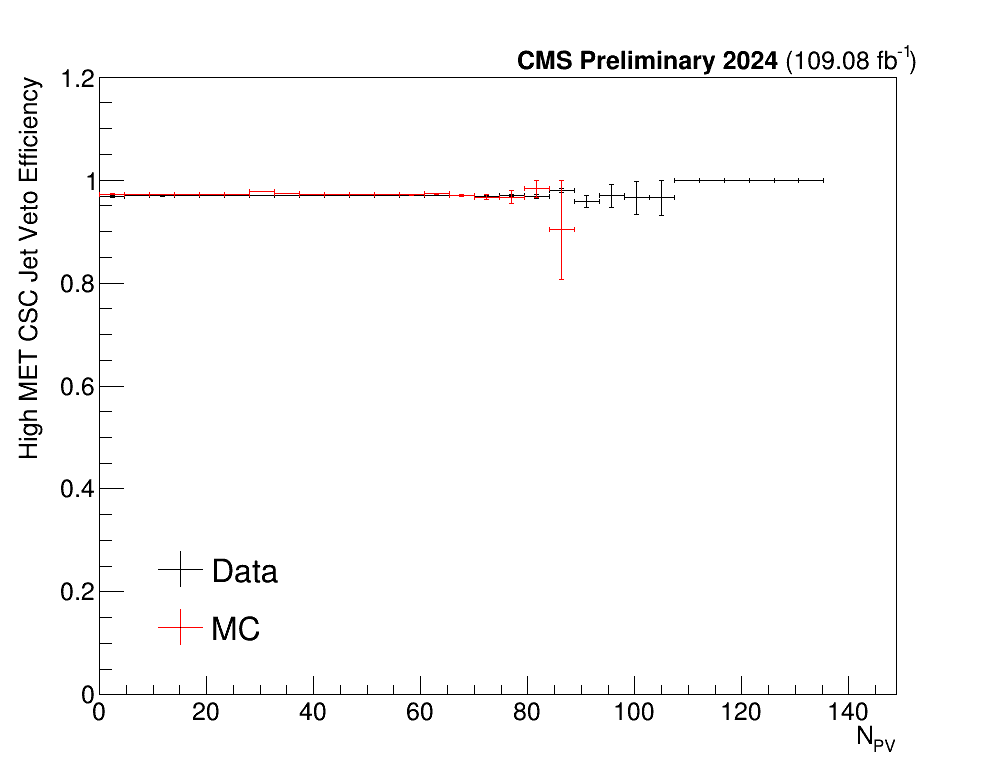

In [18]:
#make histograms

#jet veto

for campaign in list(events_data_dict.keys()):
    print(campaign)
    os.makedirs(dirNameJetVeto+"/"+campaign, exist_ok=True)
    
    
    nbins, lowBin, highBin = 30, 0, 140


    data_tree = events_data_dict[campaign]
    data_tree = data_tree[data_tree.sampledCSC]
    
    MC_tree = events_MC_dict[campaign]
    MC_tree = MC_tree[MC_tree.sampledCSC]

    #initialize data and MC histograms
    data = rt.TH1F("Data", "Data", nbinsx=nbins, xlow = lowBin, xup=highBin)
    data_num = rt.TH1F("Data_num", "Data_num", nbinsx=nbins, xlow = lowBin, xup=highBin)
    MC = rt.TH1F("MC", "MC", nbinsx=nbins, xlow = lowBin, xup=highBin)
    MC_num = rt.TH1F("MC_num", "MC_num", nbinsx=nbins, xlow = lowBin, xup=highBin)


    hist_info = {}

    #build data hist
    data_arr = np.array(data_tree["npv"], dtype=np.float64)
    data_size = np.size(data_arr)
    data_weights = np.array(data_tree.highMET_CSCWeights)
    data.FillN(data_size, data_arr, data_weights)
    data.SetLineColor(rt.kBlack)
    data.SetFillStyle(0)

    data_arr = np.array(data_tree["npv"][data_tree.passJetVeto_CSC], dtype=np.float64)
    data_size = np.size(data_arr)
    data_weights = np.array(data_tree[data_tree.passJetVeto_CSC].highMET_CSCWeights)
    data_num.FillN(data_size, data_arr, data_weights)
    data_num.SetLineColor(rt.kBlack)
    data_num.SetFillStyle(0)

    data_eff = rt.TEfficiency(data_num, data)
    data_eff.SetStatisticOption(rt.TEfficiency.kFCP)
    data_eff.SetLineColor(rt.kBlack)
    data_eff.SetTitle(";N_{PV};High MET CSC Jet Veto Efficiency")
    
    
    num = rt.TH1D("num","num",1,0,1)
    denom = rt.TH1D("denom","denom",1,0,1)
    num.SetBinContent(1,data_num.GetSumOfWeights())
    denom.SetBinContent(1,data.GetSumOfWeights())
    data_eff_val = rt.TEfficiency(num, denom)
    data_eff_val.SetStatisticOption(rt.TEfficiency.kFCP)
    print("data eff: ", data_eff_val.GetEfficiency(1), " -", data_eff_val.GetEfficiencyErrorLow(1), " + ", data_eff_val.GetEfficiencyErrorUp(1))
    
    #build MC hist
    MC_arr = np.array(MC_tree["npv"], dtype=np.float64)
    MC_size = np.size(MC_arr)
    MC_weights = np.array(MC_tree["weight_total"]*MC_tree["highMET_CSCWeights"])
    MC.FillN(MC_size, MC_arr, MC_weights)
    MC.SetLineColor(rt.kRed)
    MC.SetFillStyle(0)



    MC_arr = np.array(MC_tree["npv"][MC_tree.passJetVeto_CSC], dtype=np.float64)
    MC_size = np.size(MC_arr)
    MC_weights = np.array(MC_tree["weight_total"][MC_tree.passJetVeto_CSC]*MC_tree["highMET_CSCWeights"][MC_tree.passJetVeto_CSC])
    MC_num.FillN(MC_size, MC_arr, MC_weights)
    MC_num.SetLineColor(rt.kRed)
    MC_num.SetFillStyle(0)

    MC_eff = rt.TEfficiency(MC_num, MC)
    MC_eff.SetStatisticOption(rt.TEfficiency.kFCP) 
    MC_eff.SetLineColor(rt.kRed)
    
    
    
    
    num = rt.TH1D("num","num",1,0,1)
    denom = rt.TH1D("denom","denom",1,0,1)
    num.SetBinContent(1,MC_num.GetSumOfWeights())
    denom.SetBinContent(1,MC.GetSumOfWeights())
    data_eff_val = rt.TEfficiency(num, denom)  
    MC_eff_val = rt.TEfficiency(num, denom)
    MC_eff_val.SetStatisticOption(rt.TEfficiency.kFCP)
    print("MC eff: ", MC_eff_val.GetEfficiency(1), " -", MC_eff_val.GetEfficiencyErrorLow(1), " + ", MC_eff_val.GetEfficiencyErrorUp(1))
    
    
    C = rt.TCanvas("Jet_Veto_CSC", "Jet Veto CSC", 1000, 800)
    leg = rt.TLegend(0.15, 0.3, 0.4, 0.15)
    leg.SetBorderSize(0)
    leg.SetTextSize(0.045)
    leg.SetFillStyle(0)
    
    
        
    data_eff.Draw("E1")
    MC_eff.Draw("E1 SAME")
    C.Update()
    leg.AddEntry(data_eff, "Data", "lep")
    leg.AddEntry(MC_eff, "MC", "lep")
    leg.Draw("SAME")
    #C.Title()
    C.Draw()
    data_eff.GetPaintedGraph().GetYaxis().SetRangeUser(0,1.2)
    cmsText = rt.TLatex()
    cmsText.SetNDC(True)
    cmsText.SetTextFont(42)
    cmsText.SetTextSize(0.035)
    cmsText.SetTextAlign(11)
    if campaign=="2022":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022} (7.98 fb^{-1})")
    if campaign=="2022EE":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022} (26.67 fb^{-1})")
    if campaign=="2023":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2023} (18.41 fb^{-1})")
    if campaign=="2023BPix":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2023} (9.45 fb^{-1})")
    if campaign=="2024":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2024} (109.08 fb^{-1})")
    if campaign=="all":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022, 2023, and 2024} (171.59 fb^{-1})")
    C.SaveAs(dirNameJetVeto+"/"+campaign+"/JetVetoPlot.png")
    file = rt.TFile(dirNameJetVeto+"/"+campaign+"/JetVetoPlot.root", "RECREATE")
    #file.cd()
    C.Write()
    data.Write("Data_denom")
    data_num.Write("Data_num")
    data_eff.Write("Data_eff")
    MC.Write("MC_denom")
    MC_num.Write("MC_num")
    MC_eff.Write("MC_eff")
    file.Close()

### High MET DT

In [19]:
dirName="VetoEffPlots_highMETDT"
os.makedirs(dirName, exist_ok=True)

dirNameJetVeto = "VetoEffPlots_highMETDT/JetVeto"
dirNameRechitVeto = "VetoEffPlots_highMETDT/RechitVeto"

os.makedirs(dirNameJetVeto, exist_ok=True)
os.makedirs(dirNameRechitVeto, exist_ok=True)

2022
data eff:  0.9827518130658682  - 0.0005955017688888953  +  0.0005762790496506298
MC eff:  0.9847688540325097  - 0.0005732825254761709  +  0.0005531528025453092
2022EE
data eff:  0.9842660955236178  - 0.0003029943758278142  +  0.00029741193104204644
MC eff:  0.9841420994396013  - 0.00031283051241415283  +  0.0003069309870248338
2023
data eff:  0.9892087780866653  - 0.00029386719279766993  +  0.0002862582845635231
MC eff:  0.9829264875531519  - 0.00037190242368667636  +  0.00036419055883185614
2023BPix
data eff:  0.9895400187036227  - 0.00040473373396798795  +  0.00039007401430601885
MC eff:  0.9825109884053964  - 0.0005241826760349344  +  0.000509404197816421
2024
data eff:  0.9761394771713588  - 0.00017766328173773882  +  0.0001763868497955956
MC eff:  0.9827161696111748  - 0.00015395807615159463  +  0.0001526283925803451


Warning in <TROOT::Append>: Replacing existing TH1: Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Data_num (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_num (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: denom (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: denom (Potential 

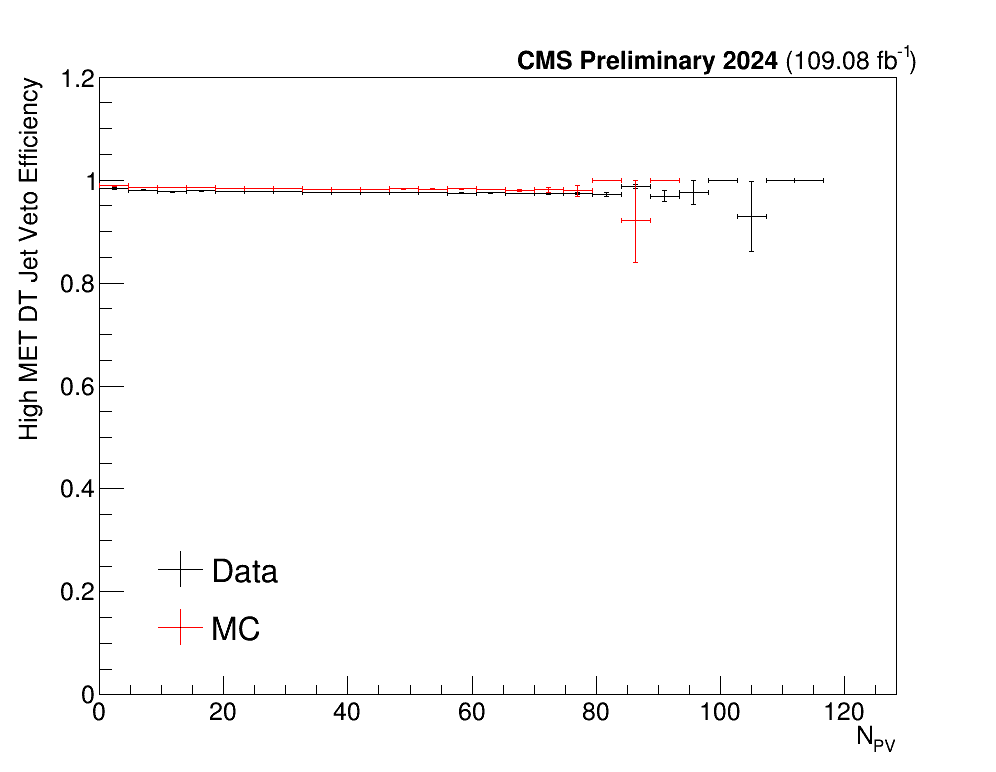

In [20]:
#make histograms

#jet veto

for campaign in list(events_data_dict.keys()):
    #if campaign!="2023BPix":continue
    print(campaign)
    os.makedirs(dirNameJetVeto+"/"+campaign, exist_ok=True)
    
    
    nbins, lowBin, highBin = 30, 0, 140


    data_tree = events_data_dict[campaign]
    data_tree = data_tree[data_tree.sampledDT]
    
    MC_tree = events_MC_dict[campaign]
    MC_tree = MC_tree[MC_tree.sampledDT]

    #initialize data and MC histograms
    data = rt.TH1F("Data", "Data", nbinsx=nbins, xlow = lowBin, xup=highBin)
    data_num = rt.TH1F("Data_num", "Data_num", nbinsx=nbins, xlow = lowBin, xup=highBin)
    MC = rt.TH1F("MC", "MC", nbinsx=nbins, xlow = lowBin, xup=highBin)
    MC_num = rt.TH1F("MC_num", "MC_num", nbinsx=nbins, xlow = lowBin, xup=highBin)


    hist_info = {}

    #build data hist
    data_arr = np.array(data_tree["npv"], dtype=np.float64)
    data_size = np.size(data_arr)
    data_weights = np.array(data_tree.highMET_DTWeights)
    data.FillN(data_size, data_arr, data_weights)
    data.SetLineColor(rt.kBlack)
    data.SetFillStyle(0)

    data_arr = np.array(data_tree["npv"][data_tree.passJetVeto_DT], dtype=np.float64)
    data_size = np.size(data_arr)
    data_weights = np.array(data_tree[data_tree.passJetVeto_DT].highMET_DTWeights)
    data_num.FillN(data_size, data_arr, data_weights)
    data_num.SetLineColor(rt.kBlack)
    data_num.SetFillStyle(0)

    data_eff = rt.TEfficiency(data_num, data)
    data_eff.SetStatisticOption(rt.TEfficiency.kFCP)
    data_eff.SetLineColor(rt.kBlack)
    data_eff.SetTitle(";N_{PV};High MET DT Jet Veto Efficiency")

    
    num = rt.TH1D("num","num",1,0,1)
    denom = rt.TH1D("denom","denom",1,0,1)
    num.SetBinContent(1,data_num.GetSumOfWeights())
    denom.SetBinContent(1,data.GetSumOfWeights())
    data_eff_val = rt.TEfficiency(num, denom)
    data_eff_val.SetStatisticOption(rt.TEfficiency.kFCP)
    print("data eff: ", data_eff_val.GetEfficiency(1), " -", data_eff_val.GetEfficiencyErrorLow(1), " + ", data_eff_val.GetEfficiencyErrorUp(1))
    
    
    
    
    #build MC hist
    MC_arr = np.array(MC_tree["npv"], dtype=np.float64)
    MC_size = np.size(MC_arr)
    MC_weights = np.array(MC_tree["weight_total"]*MC_tree["highMET_DTWeights"])
    MC.FillN(MC_size, MC_arr, MC_weights)
    MC.SetLineColor(rt.kRed)
    MC.SetFillStyle(0)



    MC_arr = np.array(MC_tree["npv"][MC_tree.passJetVeto_DT], dtype=np.float64)
    MC_size = np.size(MC_arr)
    MC_weights = np.array(MC_tree["weight_total"][MC_tree.passJetVeto_DT]*MC_tree["highMET_DTWeights"][MC_tree.passJetVeto_DT])
    MC_num.FillN(MC_size, MC_arr, MC_weights)
    MC_num.SetLineColor(rt.kRed)
    MC_num.SetFillStyle(0)
    
    #observed instance of num having larger sum of weights than denom (negative event weight thing). Won't do for every campagin to save time
    if campaign=="2023BPix":
        for binNum in range(MC_num.GetNbinsX()):
            if MC_num.GetBinContent(binNum)>MC.GetBinContent(binNum):
                MC_num.SetBinContent(binNum, MC.GetBinContent(binNum))
            

    MC_eff = rt.TEfficiency(MC_num, MC)
    MC_eff.SetStatisticOption(rt.TEfficiency.kFCP) 
    MC_eff.SetLineColor(rt.kRed)

    num = rt.TH1D("num","num",1,0,1)
    denom = rt.TH1D("denom","denom",1,0,1)
    num.SetBinContent(1,MC_num.GetSumOfWeights())
    denom.SetBinContent(1,MC.GetSumOfWeights())
    data_eff_val = rt.TEfficiency(num, denom)  
    MC_eff_val = rt.TEfficiency(num, denom)
    MC_eff_val.SetStatisticOption(rt.TEfficiency.kFCP)
    print("MC eff: ", MC_eff_val.GetEfficiency(1), " -", MC_eff_val.GetEfficiencyErrorLow(1), " + ", MC_eff_val.GetEfficiencyErrorUp(1))
    
    
    C = rt.TCanvas("Jet_Veto_DT", "Jet Veto DT", 1000, 800)
    leg = rt.TLegend(0.15, 0.3, 0.4, 0.15)
    leg.SetBorderSize(0)
    leg.SetTextSize(0.045)
    leg.SetFillStyle(0)
    
    
        
    data_eff.Draw("E1")
    MC_eff.Draw("E1 SAME")
    C.Update()
    leg.AddEntry(data_eff, "Data", "lep")
    leg.AddEntry(MC_eff, "MC", "lep")
    leg.Draw("SAME")
    #C.Title()
    C.Draw()
    data_eff.GetPaintedGraph().GetYaxis().SetRangeUser(0,1.2)
    cmsText = rt.TLatex()
    cmsText.SetNDC(True)
    cmsText.SetTextFont(42)
    cmsText.SetTextSize(0.035)
    cmsText.SetTextAlign(11)
    if campaign=="2022":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022} (7.98 fb^{-1})")
    if campaign=="2022EE":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022} (26.67 fb^{-1})")
    if campaign=="2023":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2023} (18.41 fb^{-1})")
    if campaign=="2023BPix":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2023} (9.45 fb^{-1})")
    if campaign=="2024":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2024} (109.08 fb^{-1})")
    if campaign=="all":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022, 2023, and 2024} (171.59 fb^{-1})")
    C.SaveAs(dirNameJetVeto+"/"+campaign+"/JetVetoPlot.png")
    file = rt.TFile(dirNameJetVeto+"/"+campaign+"/JetVetoPlot.root", "RECREATE")
    #file.cd()
    C.Write()
    data.Write("Data_denom")
    data_num.Write("Data_num")
    data_eff.Write("Data_eff")
    MC.Write("MC_denom")
    MC_num.Write("MC_num")
    MC_eff.Write("MC_eff")
    file.Close()

## old

In [ ]:
#make histograms

nbins, lowBin, highBin = 30, 0, 140




data_tree = events_data_dict["2022"]

MC_tree = events_MC_dict["2022"]

#initialize data and MC histograms
data = rt.TH1F("Data", "Data", nbinsx=nbins, xlow = lowBin, xup=highBin)
data_num = rt.TH1F("Data_num", "Data_num", nbinsx=nbins, xlow = lowBin, xup=highBin)
MC = rt.TH1F("MC", "MC", nbinsx=nbins, xlow = lowBin, xup=highBin)
MC_num = rt.TH1F("MC_num", "MC_num", nbinsx=nbins, xlow = lowBin, xup=highBin)


hist_info = {}

#build data hist
data_arr = np.array(data_tree["npv"], dtype=np.float64)
data_size = np.size(data_arr)
data_weights = np.ones(data_size, dtype=np.float64)
data.FillN(data_size, data_arr, data_weights)
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

data_arr = np.array(data_tree["npv"][data_tree.passJetVeto_DT], dtype=np.float64)
data_size = np.size(data_arr)
data_weights = np.ones(data_size, dtype=np.float64)
data_num.FillN(data_size, data_arr, data_weights)
data_num.SetLineColor(rt.kBlack)
data_num.SetFillStyle(0)

data_eff = rt.TEfficiency(data_num, data)
data_eff.SetStatisticOption(rt.TEfficiency.kFCP)
data_eff.SetLineColor(rt.kBlack)
data_eff.SetTitle(";N_{PV};DT Jet Veto Efficiency")

#build MC hist
MC_arr = np.array(MC_tree["npv"], dtype=np.float64)
MC_size = np.size(MC_arr)
print(MC_size)
MC_weights = np.array(MC_tree["weight_total"])
print(MC_weights)
MC.FillN(MC_size, MC_arr, MC_weights)
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)



MC_arr = np.array(MC_tree["npv"][MC_tree.passJetVeto_DT], dtype=np.float64)
MC_size = np.size(MC_arr)
print(MC_size)
MC_weights = np.array(MC_tree["weight_total"][MC_tree.passJetVeto_DT])
print(MC_weights)
MC_num.FillN(MC_size, MC_arr, MC_weights)
MC_num.SetLineColor(rt.kRed)
MC_num.SetFillStyle(0)

MC_eff = rt.TEfficiency(MC_num, MC)
MC_eff.SetStatisticOption(rt.TEfficiency.kFCP) 
MC_eff.SetLineColor(rt.kRed)

#sumOfWeights = ak.sum(MC_tree["weight_total"])

In [ ]:
C = rt.TCanvas("Jet_Veto_CSC", "Jet Veto CSC", 1000, 800)
leg = rt.TLegend(0.15, 0.4, 0.5, 0.2)
leg.SetBorderSize(0)
leg.SetTextSize(0.045)
leg.SetFillStyle(0)
data_eff.Draw("E1")
MC_eff.Draw("E1 SAME")
leg.AddEntry(data_eff, "Data", "lep")
leg.AddEntry(MC_eff, "MC", "lep")
leg.Draw("SAME")
#C.Title()
C.Draw()

In [ ]:
#make histograms

nbins, lowBin, highBin = 30, 0, 140




data_tree = events_data_dict["2022"]

MC_tree = events_MC_dict["2022"]

#initialize data and MC histograms
data = rt.TH1F("Data", "Data", nbinsx=nbins, xlow = lowBin, xup=highBin)
data_num = rt.TH1F("Data_num", "Data_num", nbinsx=nbins, xlow = lowBin, xup=highBin)
MC = rt.TH1F("MC", "MC", nbinsx=nbins, xlow = lowBin, xup=highBin)
MC_num = rt.TH1F("MC_num", "MC_num", nbinsx=nbins, xlow = lowBin, xup=highBin)


hist_info = {}

#build data hist
data_arr = np.array(data_tree["npv"], dtype=np.float64)
data_size = np.size(data_arr)
data_weights = np.ones(data_size, dtype=np.float64)
data.FillN(data_size, data_arr, data_weights)
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

data_arr = np.array(data_tree["npv"][data_tree.passMuonVeto_CSC], dtype=np.float64)
data_size = np.size(data_arr)
data_weights = np.ones(data_size, dtype=np.float64)
data_num.FillN(data_size, data_arr, data_weights)
data_num.SetLineColor(rt.kBlack)
data_num.SetFillStyle(0)

data_eff = rt.TEfficiency(data_num, data)
data_eff.SetStatisticOption(rt.TEfficiency.kFCP)
data_eff.SetLineColor(rt.kBlack)
data_eff.SetTitle(";N_{PV};CSC Muon Veto Efficiency")

#build MC hist
MC_arr = np.array(MC_tree["npv"], dtype=np.float64)
MC_size = np.size(MC_arr)
print(MC_size)
MC_weights = np.array(MC_tree["weight_total"])
print(MC_weights)
MC.FillN(MC_size, MC_arr, MC_weights)
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)



MC_arr = np.array(MC_tree["npv"][MC_tree.passMuonVeto_CSC], dtype=np.float64)
MC_size = np.size(MC_arr)
print(MC_size)
MC_weights = np.array(MC_tree["weight_total"][MC_tree.passMuonVeto_CSC])
print(MC_weights)
MC_num.FillN(MC_size, MC_arr, MC_weights)
MC_num.SetLineColor(rt.kRed)
MC_num.SetFillStyle(0)

MC_eff = rt.TEfficiency(MC_num, MC)
MC_eff.SetStatisticOption(rt.TEfficiency.kFCP) 
MC_eff.SetLineColor(rt.kRed)

#sumOfWeights = ak.sum(MC_tree["weight_total"])

In [ ]:
C = rt.TCanvas("Jet_Veto_CSC", "Jet Veto CSC", 1000, 800)
leg = rt.TLegend(0.15, 0.4, 0.5, 0.2)
leg.SetBorderSize(0)
leg.SetTextSize(0.045)
leg.SetFillStyle(0)
data_eff.Draw("E1")
MC_eff.Draw("E1 SAME")
leg.AddEntry(data_eff, "Data", "lep")
leg.AddEntry(MC_eff, "MC", "lep")
leg.Draw("SAME")
#C.Title()
C.Draw()

In [ ]:
#make histograms

nbins, lowBin, highBin = 30, 0, 140




data_tree = events_data_dict["2022"]

MC_tree = events_MC_dict["2022"]

#initialize data and MC histograms
data = rt.TH1F("Data", "Data", nbinsx=nbins, xlow = lowBin, xup=highBin)
data_num = rt.TH1F("Data_num", "Data_num", nbinsx=nbins, xlow = lowBin, xup=highBin)
MC = rt.TH1F("MC", "MC", nbinsx=nbins, xlow = lowBin, xup=highBin)
MC_num = rt.TH1F("MC_num", "MC_num", nbinsx=nbins, xlow = lowBin, xup=highBin)


hist_info = {}

#build data hist
data_arr = np.array(data_tree["npv"], dtype=np.float64)
data_size = np.size(data_arr)
data_weights = np.ones(data_size, dtype=np.float64)
data.FillN(data_size, data_arr, data_weights)
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

data_arr = np.array(data_tree["npv"][data_tree.passMuonVeto_DT_highMET], dtype=np.float64)
data_size = np.size(data_arr)
data_weights = np.ones(data_size, dtype=np.float64)
data_num.FillN(data_size, data_arr, data_weights)
data_num.SetLineColor(rt.kBlack)
data_num.SetFillStyle(0)

data_eff = rt.TEfficiency(data_num, data)
data_eff.SetStatisticOption(rt.TEfficiency.kFCP)
data_eff.SetLineColor(rt.kBlack)
data_eff.SetTitle(";N_{PV};DT High MET Muon Veto Efficiency")

#build MC hist
MC_arr = np.array(MC_tree["npv"], dtype=np.float64)
MC_size = np.size(MC_arr)
print(MC_size)
MC_weights = np.array(MC_tree["weight_total"])
print(np.sum(MC_weights))
MC.FillN(MC_size, MC_arr, MC_weights)
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)



MC_arr = np.array(MC_tree["npv"][MC_tree.passMuonVeto_DT_highMET], dtype=np.float64)
MC_size = np.size(MC_arr)
print(MC_size)
MC_weights = np.array(MC_tree["weight_total"][MC_tree.passMuonVeto_DT_highMET])
print(np.sum(MC_weights))
MC_num.FillN(MC_size, MC_arr, MC_weights)
MC_num.SetLineColor(rt.kRed)
MC_num.SetFillStyle(0)

MC_eff = rt.TEfficiency(MC_num, MC)
MC_eff.SetStatisticOption(rt.TEfficiency.kFCP) 
MC_eff.SetLineColor(rt.kRed)

#sumOfWeights = ak.sum(MC_tree["weight_total"])

In [ ]:
C = rt.TCanvas("Jet_Veto_CSC", "Jet Veto CSC", 1000, 800)
leg = rt.TLegend(0.15, 0.4, 0.5, 0.2)
leg.SetBorderSize(0)
leg.SetTextSize(0.045)
leg.SetFillStyle(0)
data_eff.Draw("E1")
MC_eff.Draw("E1 SAME")
leg.AddEntry(data_eff, "Data", "lep")
leg.AddEntry(MC_eff, "MC", "lep")
leg.Draw("SAME")
#C.Title()
C.Draw()

In [ ]:
#make histograms

nbins, lowBin, highBin = 30, 0, 140




data_tree = events_data_dict["2022EE"]

MC_tree = events_MC_dict["2022EE"]

#initialize data and MC histograms
data = rt.TH1F("Data", "Data", nbinsx=nbins, xlow = lowBin, xup=highBin)
data_num = rt.TH1F("Data_num", "Data_num", nbinsx=nbins, xlow = lowBin, xup=highBin)
MC = rt.TH1F("MC", "MC", nbinsx=nbins, xlow = lowBin, xup=highBin)
MC_num = rt.TH1F("MC_num", "MC_num", nbinsx=nbins, xlow = lowBin, xup=highBin)


hist_info = {}

#build data hist
data_arr = np.array(data_tree["npv"], dtype=np.float64)
data_size = np.size(data_arr)
data_weights = np.ones(data_size, dtype=np.float64)
data.FillN(data_size, data_arr, data_weights)
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

data_arr = np.array(data_tree["npv"][data_tree.passRechitVeto_CSC], dtype=np.float64)
data_size = np.size(data_arr)
data_weights = np.ones(data_size, dtype=np.float64)
data_num.FillN(data_size, data_arr, data_weights)
data_num.SetLineColor(rt.kBlack)
data_num.SetFillStyle(0)

data_eff = rt.TEfficiency(data_num, data)
data_eff.SetStatisticOption(rt.TEfficiency.kFCP)
data_eff.SetLineColor(rt.kBlack)
data_eff.SetTitle(";N_{PV};CSC Rechit Veto Efficiency")

#build MC hist
MC_arr = np.array(MC_tree["npv"], dtype=np.float64)
MC_size = np.size(MC_arr)
print(MC_size)
MC_weights = np.array(MC_tree["weight_total"])
print(MC_weights)
MC.FillN(MC_size, MC_arr, MC_weights)
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)



MC_arr = np.array(MC_tree["npv"][MC_tree.passRechitVeto_CSC], dtype=np.float64)
MC_size = np.size(MC_arr)
print(MC_size)
MC_weights = np.array(MC_tree["weight_total"][MC_tree.passRechitVeto_CSC])
print(MC_weights)
MC_num.FillN(MC_size, MC_arr, MC_weights)
MC_num.SetLineColor(rt.kRed)
MC_num.SetFillStyle(0)

MC_eff = rt.TEfficiency(MC_num, MC)
MC_eff.SetStatisticOption(rt.TEfficiency.kFCP) 
MC_eff.SetLineColor(rt.kRed)

#sumOfWeights = ak.sum(MC_tree["weight_total"])

In [ ]:
C = rt.TCanvas("Jet_Veto_CSC", "Jet Veto CSC", 1000, 800)
leg = rt.TLegend(0.15, 0.4, 0.5, 0.2)
leg.SetBorderSize(0)
leg.SetTextSize(0.045)
leg.SetFillStyle(0)
data_eff.Draw("E1")
MC_eff.Draw("E1 SAME")
leg.AddEntry(data_eff, "Data", "lep")
leg.AddEntry(MC_eff, "MC", "lep")
leg.Draw("SAME")
#C.Title()
C.Draw()

In [ ]:
#make histograms

nbins, lowBin, highBin = 30, 0, 140




data_tree = events_data_dict["2022EE"]

MC_tree = events_MC_dict["2022EE"]

#initialize data and MC histograms
data = rt.TH1F("Data", "Data", nbinsx=nbins, xlow = lowBin, xup=highBin)
data_num = rt.TH1F("Data_num", "Data_num", nbinsx=nbins, xlow = lowBin, xup=highBin)
MC = rt.TH1F("MC", "MC", nbinsx=nbins, xlow = lowBin, xup=highBin)
MC_num = rt.TH1F("MC_num", "MC_num", nbinsx=nbins, xlow = lowBin, xup=highBin)


hist_info = {}

#build data hist
data_arr = np.array(data_tree["npv"], dtype=np.float64)
data_size = np.size(data_arr)
data_weights = np.ones(data_size, dtype=np.float64)
data.FillN(data_size, data_arr, data_weights)
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

data_arr = np.array(data_tree["npv"][data_tree.passRechitVeto_DT], dtype=np.float64)
data_size = np.size(data_arr)
data_weights = np.ones(data_size, dtype=np.float64)
data_num.FillN(data_size, data_arr, data_weights)
data_num.SetLineColor(rt.kBlack)
data_num.SetFillStyle(0)

data_eff = rt.TEfficiency(data_num, data)
data_eff.SetStatisticOption(rt.TEfficiency.kFCP)
data_eff.SetLineColor(rt.kBlack)
data_eff.SetTitle(";N_{PV};DT Rechit Veto Efficiency")

#build MC hist
MC_arr = np.array(MC_tree["npv"], dtype=np.float64)
MC_size = np.size(MC_arr)
print(MC_size)
MC_weights = np.array(MC_tree["weight_total"])
print(MC_weights)
MC.FillN(MC_size, MC_arr, MC_weights)
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)



MC_arr = np.array(MC_tree["npv"][MC_tree.passRechitVeto_DT], dtype=np.float64)
MC_size = np.size(MC_arr)
print(MC_size)
MC_weights = np.array(MC_tree["weight_total"][MC_tree.passRechitVeto_DT])
print(MC_weights)
MC_num.FillN(MC_size, MC_arr, MC_weights)
MC_num.SetLineColor(rt.kRed)
MC_num.SetFillStyle(0)

MC_eff = rt.TEfficiency(MC_num, MC)
MC_eff.SetStatisticOption(rt.TEfficiency.kFCP) 
MC_eff.SetLineColor(rt.kRed)

#sumOfWeights = ak.sum(MC_tree["weight_total"])

In [ ]:
C = rt.TCanvas("Jet_Veto_CSC", "Jet Veto CSC", 1000, 800)
leg = rt.TLegend(0.15, 0.4, 0.5, 0.2)
leg.SetBorderSize(0)
leg.SetTextSize(0.045)
leg.SetFillStyle(0)
data_eff.Draw("E1")
MC_eff.Draw("E1 SAME")
leg.AddEntry(data_eff, "Data", "lep")
leg.AddEntry(MC_eff, "MC", "lep")
leg.Draw("SAME")
#C.Title()
C.Draw()

In [ ]:
# events_MC_dict["all"] = ak.concatenate(list(events_MC_dict.values()))
# events_data_dict["all"] = ak.concatenate(list(events_data_dict.values()))

In [ ]:
# import pickle
# with open("data_noClusters.pkl", "wb") as f:
#     pickle.dump(events_data_dict, f)
    
# with open("MC_noClusters.pkl", "wb") as f:
#     pickle.dump(events_MC_dict, f)

In [ ]:
for campaign in list(events_MC_dict.keys()):
    print(campaign)
    events_data = events_data_dict[campaign]
    events_MC = events_MC_dict[campaign]
    print("# of data events: ", ak.size(events_data.ZMass))
    print('# of MC events: ', ak.sum(events_MC.weight_total))
    print("MC k scaling factor: ", ak.size(events_data.ZMass)/ak.sum(events_MC.weight_total))

In [ ]:
rt.gStyle.SetOptStat(0)
def make_ratio_plot(campaign, h_list_in, title = "", label = "", fit = False, in_tags = None, ratio_bounds = [0.1, 4], logy = False, ratio_index = 0, draw_opt = ['E2','E1'], text = "", scale=False, scales = [1,1], return_dataMC = False):
    h_list = []
    if in_tags == None:
        tag = []
    else:
        tag = in_tags
    for i, h in enumerate(h_list_in):
        h_list.append(h.Clone('h{}aux{}'.format(i, label)))
        if in_tags == None:
            tag.append(h.GetTitle())
    #print("tags: ", tag)
    global c_out
    c_out = rt.TCanvas("c_out_ratio", "c_out_ratio", 800, 800)
    pad1 = rt.TPad("pad1a", "pad1a", 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0.03)
    pad1.SetLeftMargin(0.15)
    pad1.SetRightMargin(0.04)# pad2.SetGrid()
    if logy:
        pad1.SetLogy()

    pad1.Draw()
    pad1.cd()

    leg = rt.TLegend(0.5, 0.65, 0.9, 0.92)
    leg = rt.TLegend(0.8, 0.75, 0.93, 0.9)

    #leg = rt.TLegend(0.2, 0.7, 0.5, 0.9)
    # leg = rt.TLegend(0.7, 0.2, 0.9, 0.4)
    leg.SetBorderSize(0)
    leg.SetTextSize(0.045)
    leg.SetFillStyle(0)
    c_out.cd(1)

    scaled_h_list = []
    if scale:
        for i, h_unscaled in enumerate(h_list):
            #h = h_unscaled.Clone()
            #h = h_unscaled.Scale(1/scales[i])
            #scaled_h_list.append(h_unscaled.Clone())
            h_unscaled.Scale(1/scales[i])
            scaled_h_list.append(h_unscaled)
    else:
        #for i, h_unscaled in enumerate(h_list):
            #h = h_unscaled.Clone()
            #scaled_h_list.append(h)
        scaled_h_list = h_list
    for i, h in enumerate(scaled_h_list):
        h.GetXaxis().SetLabelSize(0)
        h.GetXaxis().SetTitle(label)
        h.GetYaxis().SetRangeUser(0, 1.1*max(map(lambda x: x.GetMaximum(), scaled_h_list)))
        if logy and not scale:
            h.GetYaxis().SetRangeUser(10e-2, 2*max(map(lambda x: x.GetMaximum(), scaled_h_list)))
        if logy and scale:
            h.GetYaxis().SetRangeUser(10e-4, 1)
        h.GetYaxis().SetTitleOffset(1.0)
        h.GetYaxis().SetTitleSize(0.06)
        h.GetYaxis().SetLabelSize(0.05)
        
        if scale:
            y_title = "Fraction of Events"
        else:
            y_title = "Events"
        
        h.GetYaxis().SetTitle()
        h.SetTitle(f";{label};{y_title}")
        #if ratio_index == 0:h.DrawCopy("hist")
        '''
        h.SetFillColor(h_list_in[i].GetLineColor())
        h.SetFillStyle(3002)
        #h.SetStats(1)
        h.SetLineColor(h_list_in[i].GetLineColor())
        h.SetLineWidth(2)
        h.SetMarkerColor(h_list_in[i].GetLineColor())
        h.SetMarkerSize(2)
        # if ratio_index == 0:
        #     # h.DrawCopy("hist")
        #     h.DrawCopy(draw_opt[i]+'same')
        # else:h.DrawCopy(draw_opt[i])
        #if ratio_index == 0 :h.DrawCopy(draw_opt[i]+"same")
        #h.DrawCopy("E2 HIST")
        '''
        if i==0:
            h.SetLineWidth(4)
            h.DrawCopy("hist")
            #h.SetFillStyle(0)
            h.SetFillColor(h_list_in[i].GetLineColor())
            h.SetFillStyle(3002)
            #h.SetStats(1)
            h.SetLineColor(h_list_in[i].GetLineColor())
            h.SetLineWidth(2)
            h.SetMarkerColor(h_list_in[i].GetLineColor())
            h.SetMarkerSize(2)
            h.DrawCopy(draw_opt[i] + "same")
            #h.SetFillStyle(0)
        else:
            h.SetLineWidth(2)
            h.DrawCopy(draw_opt[i] + "same")
        #else:h.DrawCopy(draw_opt[i])
        if len(text)>0:
            l = rt.TLatex()
            l.SetTextSize(0.045)
            if logy:l.DrawLatex((h.GetXaxis().GetXmax()-h.GetXaxis().GetXmin())*0.1+h.GetXaxis().GetXmin() , h.GetMaximum()/10, text)
            else:l.DrawLatex((h.GetXaxis().GetXmax()-h.GetXaxis().GetXmin())*0.1+h.GetXaxis().GetXmin() , h.GetMaximum()*0.8, text)
        #if i==1:
            #h.DrawCopy(draw_opt[i]+"same")
       #     h.Draw("E1 same")
        if i==1:
            leg.AddEntry(h, tag[i], "lep")
        else:
            leg.AddEntry(h, tag[i], "l")
    leg.Draw("same")
    cmsText = rt.TLatex()

    cmsText.SetNDC(True)

    #labelStr = "CMS Preliminary " + campaignStr
    cmsText.SetTextFont(42)
    cmsText.SetTextSize(0.045)
    cmsText.SetTextAlign(11)
    if campaign=="2022":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022} (7.98 fb^{-1})")
    if campaign=="2022EE":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022} (26.67 fb^{-1})")
    if campaign=="2023":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2023} (18.41 fb^{-1})")
    if campaign=="2023BPix":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2023} (9.45 fb^{-1})")
    if campaign=="2024":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2024} (109.08 fb^{-1})")
    if campaign=="all":
        cmsText.DrawLatex(0.33, 0.91, "#bf{CMS Preliminary 2022, 2023, 2024} (171.59 fb^{-1})")

    scaled_h_list_copy = [scaled_h_list[0].Clone(), scaled_h_list[1].Clone()]
    c_out.cd()
    pad2 = rt.TPad("pad2a", "pad2a", 0, 0, 1, 0.3)
    pad2.SetTopMargin(0.03)
    pad2.SetBottomMargin(0.25)
    pad2.SetLeftMargin(0.15)
    pad2.SetRightMargin(0.04)# pad2.SetGrid()
    pad2.Draw()
    pad2.cd()
    band = scaled_h_list[ratio_index].Clone('h_band')
    for j in range(band.GetXaxis().GetNbins()):
        band.SetBinContent(j+1, 1.0)
        if h_list[ratio_index].GetBinContent(j+1) == 0:
            band.SetBinError(j+1, 0.0)
        else:
            band.SetBinError(j+1, scaled_h_list[ratio_index].GetBinError(j+1)/scaled_h_list[ratio_index].GetBinContent(j+1))
            #print(j, h_list_in[0].GetBinError(j+1)/h_list_in[0].GetBinContent(j+1))
    band.SetFillColor(scaled_h_list[ratio_index].GetLineColor())

    band.SetFillStyle(3002)
    band.SetLineColor(scaled_h_list[ratio_index].GetLineColor())
    #band.SetFillColorAlpha(0,0)
    #band.SetLineColor(0)
    
    band.GetYaxis().SetTitleOffset(0.5)
    band.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
    band.GetYaxis().SetTitleSize(0.11)
    band.GetYaxis().SetLabelSize(0.12)
    band.GetYaxis().SetNdivisions(506)
    band.GetXaxis().SetTitleOffset(0.95)
    band.GetXaxis().SetTitleSize(0.12)
    band.GetXaxis().SetLabelSize(0.12)
    band.GetXaxis().SetTickSize(0.07)
    
    band.SetYTitle('Data / MC'.format(tag[ratio_index]))
    band.SetXTitle(label)
    band.SetTitle("")
    band.DrawCopy('E2')
    ln = rt.TLine(h.GetXaxis().GetXmin(), 1, h.GetXaxis().GetXmax(), 1)
    ln.SetLineWidth(3)
    ln.SetLineColor(scaled_h_list[ratio_index].GetLineColor())
    ln.DrawLine(h.GetXaxis().GetXmin(), 1, h.GetXaxis().GetXmax(), 1)
     
    #print(ratio_index)
    for i, h in enumerate(scaled_h_list):
        if i == ratio_index:
            continue
        else:
            if fit:h.GetFunction("expo")
            h.Divide(scaled_h_list[ratio_index])
            # h.GetYaxis().SetTitleOffset(0.6)
            h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
            # h.GetYaxis().SetTitleSize(0.12)
            # h.GetYaxis().SetLabelSize(0.12)
            # h.GetYaxis().SetNdivisions(506)
            # h.GetXaxis().SetTitleOffset(0.95)
            # h.GetXaxis().SetTitleSize(0.12)
            # h.GetXaxis().SetLabelSize(0.12)
            # h.GetXaxis().SetTickSize(0.07)
            # h.SetYTitle('Ratio with {}'.format(tag[0]))
            # h.SetTitle("")
            #set relative error of ratio to be the relative error of data
            for j in range(h.GetXaxis().GetNbins()):
                if h_list[i].GetBinContent(j+1) == 0:
                    h.SetBinError(j+1, 0.0)
                else:
                    h.SetBinError(j+1, h_list_in[i].GetBinError(j+1)/h_list_in[i].GetBinContent(j+1)*h.GetBinContent(j+1))
            h.Draw('same'+draw_opt[i])
    
    pad2.Update()
    
    if return_dataMC:
        return h
    
    c_out.pad1 = pad1
    c_out.pad2 = pad2
    c_out.h_list = h_list
    c_out.leg = leg
    
    
    return c_out, scaled_h_list_copy, scaled_h_list[1]

In [ ]:
#helper function to build histograms

def makeHists(events_data, events_MC, branch, bins_tuple):
    print(f"on branch {branch}")
    
    nbins, lowBin, highBin = bins_tuple
    


    data_tree = events_data

    MC_tree = events_MC

    #initialize data and MC histograms
    data = rt.TH1F("Data", "Data", nbinsx=nbins, xlow = lowBin, xup=highBin)
    MC = rt.TH1F("MC", "MC", nbinsx=nbins, xlow = lowBin, xup=highBin)


    hist_info = {}
    
    #build data hist
    data_arr = np.array(data_tree[branch], dtype=np.float64)
    data_size = np.size(data_arr)
    data_weights = np.ones(data_size, dtype=np.float64)
    data.FillN(data_size, data_arr, data_weights)
    data.SetLineColor(rt.kBlack)
    data.SetFillStyle(0)

    #build MC hist
    MC_arr = np.array(MC_tree[branch], dtype=np.float64)
    MC_size = np.size(MC_arr)
    MC_weights = np.array(MC_tree["weight_total"])
    MC.FillN(MC_size, MC_arr, MC_weights)
    MC.SetLineColor(rt.kRed)
    MC.SetFillStyle(0)

    sumOfWeights = ak.sum(MC_tree["weight_total"])

    hist_info[branch] = {"MC_hist": MC, "data_hist": data, 
                                      "MC_weights": sumOfWeights, "data_weights": data_size}
        
    return hist_info
    

In [ ]:
#define dictionary with relevant plot info
plot_info = {"ZMass": {"filename_base":"ZMass", "title":"Dimuon Mass Distribution", 
                       "xlabel":"Dimuon Mass [GeV]", "masks":[],"bins":(80, 40, 130), "logy":False},
#              "puppiMet": {"filename_base":"puppiMet", "title":"PUPPI MET Distribution", 
#                        "xlabel":"PUPPI MET [GeV]", "masks":[],"bins":(60, -5, 100), "logy":False},
#             "puppiMetPhi": {"filename_base":"puppiMetPhi", "title":"PUPPI MET Phi Distribution", 
#                        "xlabel":"PUPPI MET Phi", "masks":[],"bins":(30, -4, 4), "logy":False},
            "probe_pT": {"filename_base":"probe_pT", "title":"pT of Muon Matched to Cluster", 
                       "xlabel":"pT [GeV]", "masks":[],"bins":(25, 0, 100), "logy":False},
#            "tag_pT": {"filename_base":"tag_pT", "title":"pT of Muon Not Matched to Cluster", 
#                       "xlabel":"pT [GeV]", "masks":[],"bins":(25, 0, 100), "logy":False},
#             "probe_phi": {"filename_base":"probe_phi", "title":"Phi of Muon Matched to Cluster", 
#                        "xlabel":"pT [GeV]", "masks":[],"bins":(60, -4, 4), "logy":False},
#             "tag_phi": {"filename_base":"tag_phi", "title":"Phi of Muon Not Matched to Cluster", 
#                        "xlabel":"pT [GeV]", "masks":[],"bins":(60, -4, 4), "logy":False},
#             "probe_eta": {"filename_base":"probe_eta", "title":"Eta of Muon Matched to Cluster", 
#                        "xlabel":"pT [GeV]", "masks":[],"bins":(60, -4, 4), "logy":False},
#             "tag_eta": {"filename_base":"tag_eta", "title":"Eta of Muon Not Matched to Cluster", 
#                        "xlabel":"pT [GeV]", "masks":[],"bins":(60, -4, 4), "logy":False},
            }

In [ ]:
individual_plot_info_dict = {}
for campaign in list(events_MC_dict.keys()):
    print(campaign)
    individual_plot_info = {}
    events_data = events_data_dict[campaign]
    events_MC = events_MC_dict[campaign]
    for branch, info_dict in plot_info.items():
        filename_base = info_dict["filename_base"]
        hist_dict = makeHists(events_data, events_MC, branch, info_dict["bins"])
        for plot_hists, plot_hist_dict in hist_dict.items():
            individual_plot_info[plot_hists] = {"MC_hist": plot_hist_dict["MC_hist"], "data_hist": plot_hist_dict["data_hist"], 
                        "file_name": plot_hists, "title": info_dict["title"], "label": info_dict["xlabel"], 
                        "scales": [plot_hist_dict["MC_weights"], plot_hist_dict["data_weights"]], "logy": info_dict["logy"]}
        individual_plot_info_dict[campaign] = individual_plot_info


In [ ]:
for campaign in list(events_MC_dict.keys()):
    print(campaign)
    plot_output = f"{campaign}_Data_MC_Comp_noClusters_correctSFs"
    os.makedirs(plot_output, exist_ok=True)
    
    individual_plot_info = individual_plot_info_dict[campaign]
    for plot_type, plot_info_dict in individual_plot_info.items():
        print(plot_type)
        for boolScale in [True, False]:
            c, h_list, ratio = make_ratio_plot(campaign, [plot_info_dict["MC_hist"], plot_info_dict["data_hist"]], title = plot_info_dict["title"], label = plot_info_dict["label"], fit = False, in_tags = None, ratio_bounds = [0.1, 4], logy = plot_info_dict["logy"], ratio_index = 0, draw_opt = ['E2','E1'], text = "", scale=boolScale, scales = plot_info_dict["scales"])
            if boolScale:
                scaleString = "_normalized"
            else:
                scaleString=""
            os.makedirs(plot_output+"/"+plot_info_dict["file_name"], exist_ok=True)
            c.SaveAs(plot_output+"/"+plot_info_dict["file_name"]+"/"+plot_info_dict["file_name"]+scaleString+"_updatedTNP.png")
            file = rt.TFile(plot_output+"/"+plot_info_dict["file_name"]+"/"+plot_info_dict["file_name"]+scaleString+".root", "RECREATE")
            #file.cd()
            c.Write()
            h_list[0].Write("MC_hist")
            h_list[1].Write("Data_hist")
            ratio.Write("Data_MC_Ratio")
            file.Close()